In [107]:
import scipy
import numpy as np
import seaborn as sns
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Multiple testing

In the typical multiple testing scenario, we have $m$ hypotheses that we want to test.

There are two types of error rates we might want to control for:
1. The family-wise error rate (FWER)
2. The false discovery rate (FDR / pFDR)

For the latter, we can look at either FDR (Benjamini-Hochberg):
$$FDR = \mathbb{E}\left(\frac{V}{R} \,|\, R > 0 \right) \Pr(R > 0)$$
or the pFDR
$$pFDR = \mathbb{E}\left(\frac{V}{R} \,|\, R > 0 \right),$$
where the ratio
$\frac{V}{R}$ is defined to be the number of false positives $V$ (rejected null, when the null is true) divided by the total number of rejected nulls $R$.

## Testing images
For instance, we may have an image with $m$ pixels, and we may have 2 groups that we want to identify which pixels
are different between the groups, e.g., to identify unusual brain activity.

## Testing difference in gene expression
Another example would be if we had tumor cells and normal cells and wanted to test for a difference in the expression of certain genes between the two groups.

# Example setting

Suppose we have $i = 1,\ldots,n$ individuals and $j = 1,\ldots, m$ index pixels in an image.

Suppose we have 2 treatments: control and patient, or $k=0,1$.
Let $D_{ij}$ denote the difference between the measurements in the two treatments:
$$D_{ij} := Y_{ij0} - Y_{ij1},$$
where $Y_{ijk}$ is the measurement on individual $i$, pixel $j$, and treatment $k$.
Thus, $D$ is an $n \times m$ matrix (individuals by pixels).

## Hierarchical model

Suppose we had the following model for $D$:
$$ D_{ij} | \beta, \sigma \sim N(\beta_j, \sigma_j),$$
where $\beta = (\beta_1,\ldots,\beta_m)$ is a vector of treatment effects --- each $\beta_j$ is the effect at pixel $j$, and $\sigma = (\sigma_1,\ldots,\sigma_j$ is a vector of standard deviation parameters.

The true effects $\beta_j$ are iid from a mixture model
$$\beta_j \sim \pi_0\delta_0 + (1-\pi_0) N(0, \sigma^2_b),$$
where $\delta_0$ is a point mass at 0, and $\pi_0$ is the mixture weight (between 0 and 1). 

In [209]:
import numpy as np
def generate_data(n, m, pi0, sigmab):
    # generate beta_j's
    beta = np.zeros(m)
    for j in range(m):
        if np.random.random() < pi0:
            beta[j] = 0
        else:
            beta[j] = np.random.normal(0,sigmab)
    
    D = np.zeros((n,m))
    sigma = np.ones(m)
    for i in range(n):
        D[i] = np.random.normal(beta, sigma)
        
    return D, beta   

# Generate data from the model
D1, beta1 = generate_data(10, 10000, 1, 3) # only generate from 0
D2, beta2 = generate_data(10, 10000, 0.5, 3)
D3, beta3 = generate_data(10, 10000, 0., 3) # only generate from normal

## Hypotheses to test

For each pixel $j = 1,\ldots,m$, we want to test the null hypothesis
$$H_j : \beta_j = 0,$$
i.e., there is no treatment effect.

We assume $\sigma_j = 1$ for all $j=1,\ldots,m$.

Here we'll use a 2-sided $z$-test, where the test statistic is computed as:
$$T_j = (\frac{1}{n} \sum_{i,j} D_{ij} - \beta_j) / s,$$
where $s = \sqrt{n}$, since we assumed $\sigma_j =1$.

In [210]:
def compute_p_value(dat, beta):
    # using a z-test
    n, m = dat.shape
    T = dat.mean(0) / np.sqrt(n)
    return np.array([ztest(dat[:,j])[1] for j in range(m)])
    
pvalues1 = compute_p_value(D1, beta1)
pvalues2 = compute_p_value(D2, beta2)
pvalues3 = compute_p_value(D3, beta3)

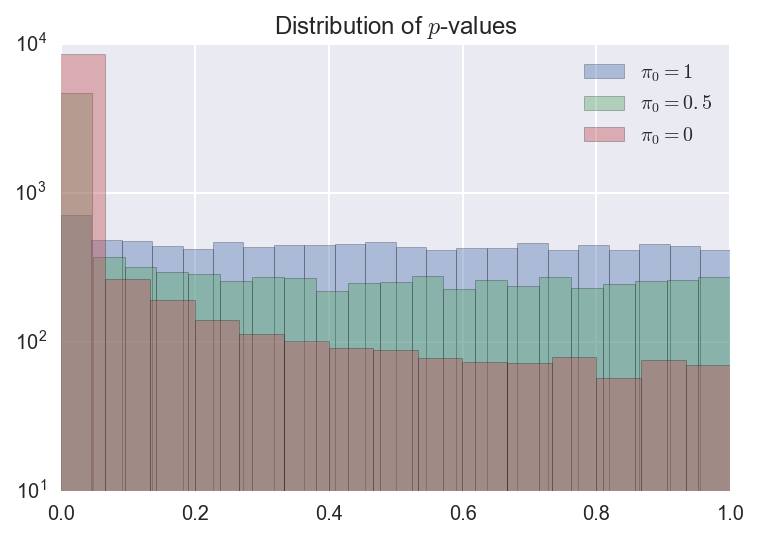

In [211]:
pylab.clf()
sns.distplot(pvalues1, kde=False)
sns.distplot(pvalues2, kde=False)
sns.distplot(pvalues3, bins=15, kde=False)
pylab.legend([r'$\pi_0=1$', r'$\pi_0=0.5$', r'$\pi_0=0$'], loc='upper right')
pylab.title(r"Distribution of $p$-values")
pylab.yscale('log')

We can see from the histogram plots of the $p$-values that when $\pi_0=1$, we are only generating from mean $0$ (null hypothesis, in blue), the $p$-values are uniformly distributed, and as we increase the mixture weight $\pi_0$, the $p$-values get more concentrated toward 0, i.e., we want to reject the null hypothesis.

In [452]:
## The Benjamini-Hochberg rule to control FDR at level alpha
def FDR_control(pvalues, alpha):
    # sort p-values
    m = len(pvalues)
    reject = np.zeros(m)
    inds = pvalues.argsort()
    sorted_p = pvalues[inds]
    thresh = np.arange(1,m+1) * alpha / m
    for i, p in enumerate(sorted_p):
        if p <= thresh[i]:
            reject[inds[i]] = 1
        else:
            #print('stopping at index: %d' % i)
            return reject
        
def compute_FDR_full(hypotheses, beta):
    V = sum(beta[hypotheses == 1.] == 0.)
    R = hypotheses.sum()

    if R == 0:
        return 0, 0
    else:
        return float(V)/R, R

def simulate_FDR(pi0, num_iter=5):
    #alpha = [0.01, 0.05, 1.5, 0.5]
    alpha = [0.01, 0.05, 0.1, 0.5]
    FDRs = []
    pFDRs = []
    
    for a in alpha:
        
        VRs = np.arange(num_iter)
        Rs = np.arange(num_iter) 
        # generate several datasets from these parameters and compute FDR averaged over the datasets
        for i in range(num_iter):
            D, beta = generate_data(10, 10000, pi0, 3)
            pvalues = compute_p_value(D, beta)
            hypo = FDR_control(pvalues, a)
            VR, R = compute_FDR_full(hypo, beta)
            VRs[i] = VR; Rs[i] = R
        
        # compute expected V/R
        pFDR = VRs[Rs > 0].mean()
        pFDRs.append(pFDR)
        FDRs.append(pFDR * float((Rs > 0).sum())/len(Rs))

    return pFDRs, FDRs

In [453]:
pFDRs1, FDRs1 = simulate_FDR(1., num_iter=5)
pFDRs2, FDRs2 = simulate_FDR(0.5)
pFDRs3, FDRs3 = simulate_FDR(0)

In [466]:
#pylab.plot(range(len(pFDRs1)), pFDRs1)
#pylab.plot(range(len(pFDRs2)), pFDRs2)
#pylab.plot(range(len(pFDRs3)), pFDRs3)